In [2]:
from os import listdir, mkdir
from os.path import isfile, join, isdir
from json import loads
from re import findall,UNICODE
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *
from bookclass import *

from tqdm import tqdm

In [3]:
# all our essentials
from matplotlib import rc,rcParams
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica Neue')
# rc('text', usetex='false') 

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='true') 

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn import metrics

In [5]:
filters = {"min_dl":40,
           "length": [20000,100000],
           "P": True,
           "n_points": 200,
           "salad": False,
          }
q = get_books(Book,filters)
version_str = get_version_str(filters)
this_dir = join("/Users/andyreagan/projects/2014/09-books/media/figures/clustering",version_str)
if not isdir(this_dir):
    mkdir(this_dir)
big_matrix = get_data(q,version_str,filters,use_cache=True)
big_matrix_mean0 = big_matrix-np.tile(big_matrix.mean(axis=1),(200,1)).transpose()
big_matrix_start0 = big_matrix-np.tile(big_matrix[:,0],(200,1)).transpose()
print(big_matrix.shape)

(1385, 200)


In [6]:
# pre compute the full distance matrix
# ouch

# the city block distance betwen two vectors
def cityBlock(a,b):
    return np.sum(np.abs(a-b))

# define a quick cache for this one...
if isfile("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-matrix-cache-{}.p".format(version_str)):
    allDistances = pickle.load(open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-matrix-cache-{}.p".format(version_str),"rb"))
    allDistancesCentered = pickle.load(open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-mean0-matrix-cache-{}.p".format(version_str),"rb"))
    allDistancesStart = pickle.load(open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-start0-matrix-cache-{}.p".format(version_str),"rb"))
else:
    pairWiseDistances = np.zeros([big_matrix.shape[0],big_matrix.shape[0]])
    pairWiseDistancesCentered = np.zeros([big_matrix_mean0.shape[0],big_matrix_mean0.shape[0]])
    pairWiseDistancesStart = np.zeros([big_matrix_start0.shape[0],big_matrix_start0.shape[0]])
    for i in range(big_matrix.shape[0]):
        if i%100 == 0:
            print(i)
        # compute only the upper diagonal
        for j in range(i,big_matrix.shape[0]):
            pairWiseDistances[i,j] = cityBlock(big_matrix[i,:],big_matrix[j,:])
            pairWiseDistancesCentered[i,j] = cityBlock(big_matrix_mean0[i,:],big_matrix_mean0[j,:])
            pairWiseDistancesStart[i,j] = cityBlock(big_matrix_start0[i,:],big_matrix_start0[j,:])
    # build the full matrices
    allDistances = pairWiseDistances+np.transpose(pairWiseDistances)
    allDistancesCentered = pairWiseDistancesCentered+np.transpose(pairWiseDistancesCentered)
    allDistancesStart = pairWiseDistancesStart+np.transpose(pairWiseDistancesStart)

In [7]:
pickle.dump(allDistances,open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-matrix-cache-{}.p".format(version_str),"wb"),pickle.HIGHEST_PROTOCOL)
pickle.dump(allDistancesCentered,open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-mean0-matrix-cache-{}.p".format(version_str),"wb"),pickle.HIGHEST_PROTOCOL)
pickle.dump(allDistancesStart,open("/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-start0-matrix-cache-{}.p".format(version_str),"wb"),pickle.HIGHEST_PROTOCOL)

In [8]:
# metric = "cityblock"
# # go to two clusters on the top
# n_clusters = 2

# model = AgglomerativeClustering(n_clusters=n_clusters,
#                                 linkage="average",
#                                 affinity=metric,
#                                 compute_full_tree=True)

# # using the scipy implementation instead
# model.fit(big_matrix)

# print(model.labels_)
# print(model.labels_.size)

# print(model.n_leaves_)
# print(model.children_)
# children = np.array(model.children_,dtype=np.float64)

In [22]:
# # this seems okay, but city block is not what I want here (that was
# # already used for dimension reduction)
# method = 'average'
# metric = 'cityblock'

# this will generate more uniform clusters
method = 'ward'
metric = 'euclidean'

from scipy.cluster.hierarchy import dendrogram,linkage
fit = linkage(allDistances,metric=metric,method=method)
fit2 = linkage(allDistancesCentered,metric=metric,method=method)
fit3 = linkage(allDistancesStart,metric=metric,method=method)

In [23]:
# let's try to understand this matrix fit
# A 4 by (n-1) matrix Z is returned.
print(allDistances.shape)
print(fit.shape)
print("this is (n-1) by 4, as expected")
print("-"*20)

# At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] 
# are combined to form cluster n + i.
print("...so at iteration n+i, fit[-1,:] we find:")
print(fit[-1,:])
print("-"*20)
# old indices:
# this means clusters 6152 and 6153 were combined to form cluster 3077+3077=6154
# new indices?
# this means clusters fit[-1,0] and fit[-1,1] were combined to form cluster 1755+1755=3510

# A cluster with an index less than n corresponds to one of the original observations.
#...so cluster 0, cluster 3000 are the books at 0, and 3000, themselves

# The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2].
# ...so the distance between clusters 6152 and 6153 is 72466

# The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.
# ...and, we now have all of the books in that cluster

print(fit[0,:])
print(fit[1,:])
print("...")
print(fit[-2,:])
print(fit[-1,:])

(1385, 1385)
(1384, 4)
this is (n-1) by 4, as expected
--------------------
...so at iteration n+i, fit[-1,:] we find:
[  2765.           2767.          28632.56635703   1385.        ]
--------------------
[ 245.         340.           1.6967969    2.       ]
[ 238.          337.            5.30651513    2.        ]
...
[  2764.           2766.          21719.06257673   1106.        ]
[  2765.           2767.          28632.56635703   1385.        ]


In [24]:
# define a threshold
threshold = 70000
# and we'll go get all of the clusters that are merged under that threshold
# ...this has the effect of slicing the dendrogram at any height

# a dangerously recursive function
def get_children():
    c = []
    if not True:
        get_children()
    return c

def get_cluster_indices(model,threshold=70000,return_cluster_names=False):
    cluster_list = np.array([i for i in range(allDistances.shape[0])])
    for i,merge in enumerate(model):
        if merge[2] < threshold:
            # print(merge)
            # print(int(merge[0]))
            a = cluster_list==int(merge[0])
            cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
            cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
    # print(cluster_list[:10])
    # print(cluster_list[1730:1740])
    clusters = np.unique(cluster_list)
    a = np.arange(allDistances.shape[0])
    indices = [a[cluster_list==c] for c in clusters]
    num_clusters = len(indices)
    cluster_sizes = list(map(len,indices))
    # print('found {0} clusters of sizes:'.format(num_clusters))
    # print(cluster_sizes)
    if return_cluster_names:
        return indices,num_clusters,cluster_sizes,cluster_list
    else:
        return indices,num_clusters,cluster_sizes
    
def get_cluster_indices_from_id(model,cluster_id):
    if cluster_id < allDistances.shape[0]:
        return np.array([cluster_id])
    cluster_list = np.array([i for i in range(allDistances.shape[0])])
    for i,merge in enumerate(model):
        if merge[2] <= model[cluster_id-allDistances.shape[0]+1,2]:
            # print(merge)
            # print(int(merge[0]))
            a = cluster_list==int(merge[0])
            cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
            cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
    a = np.arange(allDistances.shape[0])
    # print(cluster_list)
    indices = a[cluster_list==cluster_id]
    return indices

ind,nc,cs = get_cluster_indices(fit,threshold=70000)
ind,nc,cs = get_cluster_indices(fit,threshold=40000)
ind,nc,cs = get_cluster_indices(fit,threshold=25000)
ind,nc,cs = get_cluster_indices(fit,threshold=20000)
ind,nc,cs,cluster_list = get_cluster_indices(fit,threshold=5000,return_cluster_names=True)
print('checking the new function')
print(cluster_list)
print(cluster_list==cluster_list[0])
# print(ind[0])
ind = get_cluster_indices_from_id(fit,cluster_list[0])
print(ind)
print(len(ind))
ind,nc,cs = get_cluster_indices(fit2,threshold=25000)
ind,nc,cs = get_cluster_indices(fit2,threshold=11000)
ind,nc,cs = get_cluster_indices(fit2,threshold=5000)
ind,nc,cs = get_cluster_indices(fit2,threshold=2000)

checking the new function
[2760 2760 2758 ..., 2761 2760 2760]
[ True  True False ..., False  True  True]
[   0    1   16   18   19   27   36   38   42   47   56   76   77   80   82
  100  106  114  118  125  133  134  135  136  138  142  143  146  147  148
  149  152  153  156  159  162  166  167  168  170  174  190  194  195  199
  201  203  205  206  209  215  216  221  222  223  225  226  227  240  242
  244  248  249  254  258  262  264  267  269  270  274  275  277  278  279
  283  285  295  296  301  304  318  325  328  338  339  343  344  345  347
  349  350  351  355  356  358  362  367  368  372  374  377  378  382  384
  387  389  390  394  410  411  416  417  418  427  428  432  433  434  458
  459  460  464  468  469  470  473  474  475  476  477  478  479  480  489
  490  496  503  507  511  514  515  517  519  520  521  528  529  532  533
  538  542  543  545  549  554  557  562  568  569  573  574  576  577  582
  585  588  594  595  606  609  616  617  618  619  621  6

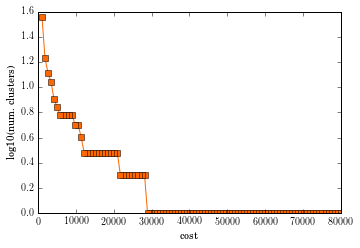

In [25]:
x = np.linspace(80000,1000,num=100)
y = np.zeros([100,1])
for i,cost in enumerate(x):
    ind,nc,cs = get_cluster_indices(fit,threshold=cost)
    y[i] = nc
fig = plt.figure()
ax = fig.add_axes([.2,.2,.7,.7])
ax.plot(x,np.log10(y),'s-',color='#ff6700')
ax.set_ylabel('log10(num. clusters)')
ax.set_xlabel('cost')
# mysavefig('heirarchal-clustering-cost.svg')

In [26]:
R = dendrogram(fit,distance_sort='ascending',no_plot=True,truncate_mode='lastp')

In [27]:
# R = dendrogram(fit,distance_sort='ascending')

In [28]:
ind,nc,cs,cluster_list = get_cluster_indices(fit3,threshold=655,return_cluster_names=True)

In [29]:
R

{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'r',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'c',
  'b',
  'b'],
 'dcoord': [[0.0, 1478.7495455588378, 1478.7495455588378, 0.0],
  [0.0, 2484.0586671449942, 2484.0586671449942, 0.0],
  [1478.7495455588378,
   4033.7101785314599,
   4033.7101785314599,
   2484.0586671449942],
  [0.0, 1516.3078777470243, 1516.3078777470243, 0.0],
  [0.0, 2125.1256194675575, 2125.1256194675575, 0.0],
  [1516.3078777470243,
   4231.129076270925,
   4231.129076270925,
   2125.1256194675575],
  [4033.7101785314599,
   11155.629063988617,
   11155.629063988617,
   4231.129076270925],
  [0.0, 1414.2928043953814, 1414.2928043953814, 0.0],
  [0.0, 1629.7843998019862, 1629.7843998019862, 0.0],
  [0.0, 2338.9493002024242, 2338.9493002024242, 1629.7843998019862],
  [1414.2928043953814,
   3313.0189019278205,
   3313.0189019278205,
   2338.9493002024242],
  [0.0, 14

In [30]:
leaves = R['leaves']
print('leaves:')
print(leaves[:10])

leaves:
[2700, 2723, 2722, 2739, 2617, 2703, 2706, 2731, 2715, 2734]


In [31]:
indices_sorted = [get_cluster_indices_from_id(fit,leaf) for leaf in R['leaves']]

In [32]:
print(indices_sorted[:10])

[array([  50,  137,  257,  266,  379,  386,  649,  710,  753,  886,  888,
        923, 1032]), array([  10,   21,   62,   91,  180,  218,  383,  407,  448,  498,  541,
        548,  601,  734,  737,  795,  840,  853,  881,  898,  901,  917,
        924,  955,  964,  965,  969, 1004, 1039, 1064, 1069, 1109, 1174,
       1192, 1198, 1201, 1207, 1242, 1261, 1271, 1301, 1365]), array([  24,   63,  121,  210,  231,  232,  246,  259,  260,  305,  316,
        327,  329,  341,  348,  352,  359,  376,  391,  400,  425,  440,
        447,  485,  501,  625,  632,  648,  688,  689,  736,  741,  742,
        748,  749,  771,  787,  791,  792,  800,  808,  887,  894,  904,
        906,  910,  929,  951,  963,  977,  992,  996,  999, 1028, 1034,
       1058, 1097, 1121, 1128, 1194, 1196, 1214, 1220, 1223, 1224, 1226,
       1228, 1240, 1243, 1309, 1317, 1343, 1372, 1382]), array([  20,   22,   26,   35,   55,   61,   67,   92,  105,  126,  130,
        169,  193,  238,  245,  252,  294,  306,  315, 

In [33]:
len(indices_sorted)

30

In [34]:
# but hey, some of them are empty!!

(1384, 4)
1.69679690181
28632.566357


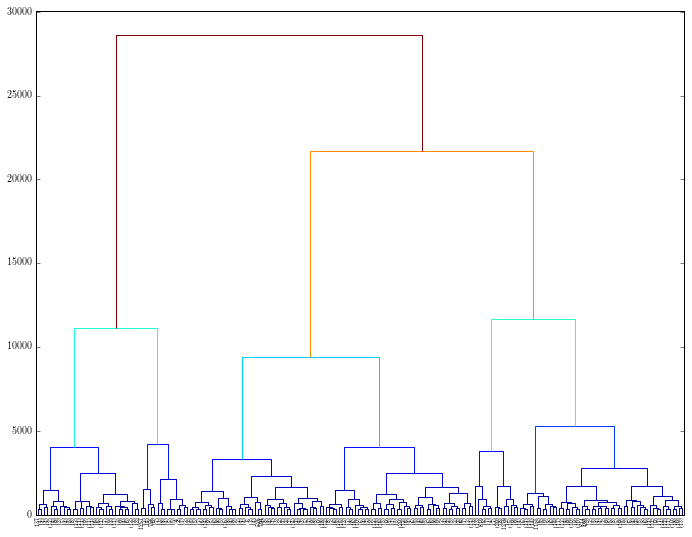

In [35]:
figsize=10
p=200
fig = plt.figure(figsize=(figsize,figsize))
ax = fig.add_axes([0.1,0.3,0.9,0.7])
colors = ['k' for i in range(fit.shape[0]*2)]

alltitles = [q[i].title for i in range(len(q))]

print(fit.shape)

cm = plt.get_cmap('jet')
print(fit[0,2])
print(fit[-1,2])

from matplotlib.colors import rgb2hex

def printcolor(k,yes='yes'):
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    return rgb2hex(cm(fit[k-fit.shape[0]-1,2]/fit[-1,2]))

def llf(k):
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    return alltitles[k-fit.shape[0]-1]

R = dendrogram(fit,
               p=p,
               truncate_mode='lastp',
               link_color_func=lambda k: printcolor(k,yes='n'),
               ax=ax,
               # leaf_rotation=0.,
               # labels=alltitles,
               # leaf_label_func=llf,
               # leaf_label_func=lambda k: q[k].title,
               # orientation='right',
               orientation='top',
               # no_labels=True,
               )

# # ax.set_yscale('log')
# # ax.set_ylim([5,fit[-1,2]])
# tmp = ax.xaxis.get_ticklabels()
# # print(tmp)

# # ind,nc,cs,cluster_list = get_cluster_indices(fit,threshold=655,return_cluster_names=True)
# # index_index = [np.where(np.unique(cluster_list)==leaves[i]) for i in range(200)]
# # indices_sorted = [ind[index_index[i]] for i in range(200)]
# # titles_sorted = [alltitles[ind[0]] for ind in indices_sorted]
# tmp2 = ax.get_xticks()
# ax.set_xticks(ax.get_xticks())
# # tmp3 = ax.set_xticklabels(ax.get_xticks(),justtitles, ha='right', rotation=-80)
# # tmp4 = plt.xticks(ax.get_xticks(),justtitles, ha='left', rotation=-80)
# # mysavefig('dendrogram-{0}x{0}-truncatelastp-p{1}.svg'.format(figsize,p))

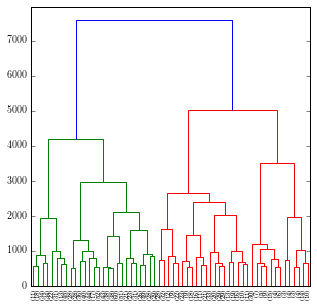

In [36]:
figsize=5
p=60
plt.figure(figsize=(figsize,figsize))
R = dendrogram(fit2,p=p,truncate_mode='lastp')
# mysavefig('dendrogram-{0}x{0}-truncatelastp-p{1}-centered.svg'.format(figsize,p))

In [37]:
[x for x in R]

['leaves', 'dcoord', 'color_list', 'icoord', 'ivl']

In [38]:
R['leaves'][:10]

[2598, 2657, 2677, 2699, 2700, 2688, 2605, 2704, 2603, 2675]

In [39]:
R['dcoord'][:10]

[[0.0, 572.03045073810449, 572.03045073810449, 0.0],
 [0.0, 652.67419036998524, 652.67419036998524, 0.0],
 [572.03045073810449,
  891.02271933629254,
  891.02271933629254,
  652.67419036998524],
 [0.0, 624.19628836902586, 624.19628836902586, 0.0],
 [0.0, 808.50936091104984, 808.50936091104984, 624.19628836902586],
 [0.0, 995.09667918333184, 995.09667918333184, 808.50936091104984],
 [891.02271933629254,
  1935.5089549712893,
  1935.5089549712893,
  995.09667918333184],
 [0.0, 529.77979829202934, 529.77979829202934, 0.0],
 [0.0, 719.59364443699212, 719.59364443699212, 0.0],
 [0.0, 555.61826499805193, 555.61826499805193, 0.0]]

In [40]:
R['icoord'][:10]

[[5.0, 5.0, 15.0, 15.0],
 [25.0, 25.0, 35.0, 35.0],
 [10.0, 10.0, 30.0, 30.0],
 [65.0, 65.0, 75.0, 75.0],
 [55.0, 55.0, 70.0, 70.0],
 [45.0, 45.0, 62.5, 62.5],
 [20.0, 20.0, 53.75, 53.75],
 [85.0, 85.0, 95.0, 95.0],
 [105.0, 105.0, 115.0, 115.0],
 [135.0, 135.0, 145.0, 145.0]]

In [51]:
R['ivl'][:10]

['(11) The Return of Dr. Fu-Manchu',
 '(18) Bull Hunter',
 '(34) Book of Wise Sayings: Selected Largely from East...',
 '(34) De Profundis',
 '(22) The Idle Thoughts of an Idle Fellow',
 "(31) India's Love Lyrics",
 '(13) A Little Princess\r: Being the whole story of Sar...',
 '(45) Oliver Twist, Vol. 2 (of 3)',
 '(28) Visions and Revisions: A Book of Literary Devotions',
 '(28) Small Means and Great Ends']

In [52]:
[(x,len(R[x])) for x in R]

[('leaves', 60),
 ('dcoord', 59),
 ('color_list', 59),
 ('icoord', 59),
 ('ivl', 60)]

In [42]:
now = datetime.now()
sorted_fname_now = now.strftime("/Users/andyreagan/projects/2014/09-books/data/gutenberg/%Y-%m-%d-%H-%M-pairwise-distance-matrix-sorted-cache-{}.p".format(version_str))
sorted_fname = "/Users/andyreagan/projects/2014/09-books/data/gutenberg/pairwise-distance-matrix-sorted-cache-{}.p".format(version_str)
if isfile(sorted_fname):
    print("loading from file")
    allDistancesSorted = pickle.load(open(sorted_fname,"rb"))
else:
    print("remaking")
    R = dendrogram(fit2,distance_sort='ascending',no_plot=True)
    leaveList = np.array(R['leaves'])
    allDistancesSorted = np.zeros([big_matrix.shape[0],big_matrix.shape[0]])
    for i in range(big_matrix.shape[0]):
        # print(i)
        # compute only the upper diagonal
        # for j in range(big_matrix.shape[0]):
        #    allDistancesSorted[i,j] = cityBlock(big_matrix[leaveList[i],:],big_matrix[leaveList[j],:])
        allDistancesSorted[i,:] = allDistancesCentered[i,leaveList]
    allDistancesSorted = allDistancesSorted[leaveList,:]
    pickle.dump(allDistancesSorted,open(sorted_fname,"wb"),pickle.HIGHEST_PROTOCOL)
    pickle.dump(allDistancesSorted,open(sorted_fname_now,"wb"),pickle.HIGHEST_PROTOCOL)

loading from file


98.6855335438


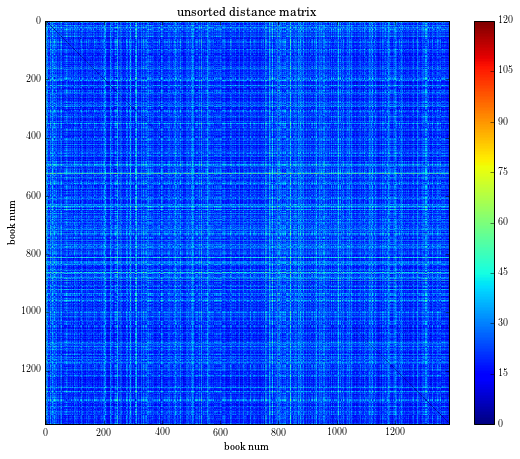

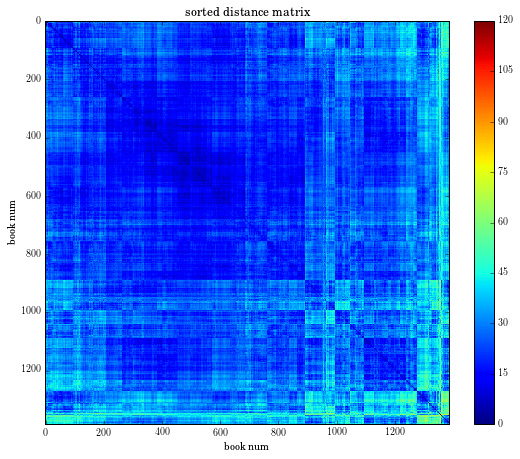

In [43]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
# screw memory...I have a SSD!

print(allDistancesCentered.max())

cax = plt.imshow(allDistancesCentered)
# ax1.colorbar()
plt.colorbar(cax,ax=ax1,shrink=0.8)
plt.clim([0,120])
ax1.set_title('unsorted distance matrix')
ax1.set_xlabel('book num')
ax1.set_ylabel('book num')
# plt.colorbar?
# mysavefig('unsorted-distance-matrix.png')
# mysavefig('unsorted-distance-matrix.svg')

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
# ax1 = plt.subplot(1,2,2)
cax = plt.imshow(allDistancesSorted)
# ax1.colorbar()
plt.colorbar(cax,ax=ax1,shrink=0.8)
plt.clim([0,120])
ax1.set_title('sorted distance matrix')
ax1.set_xlabel('book num')
ax1.set_ylabel('book num')
# plt.colorbar?
# mysavefig('sorted-distance-matrix.png')
# mysavefig('sorted-distance-matrix.svg')

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1382 1382 1382 ..., 1382 1382 1382]
 [1383 1383 1383 ..., 1383 1383 1383]
 [1384 1384 1384 ..., 1384 1384 1384]]


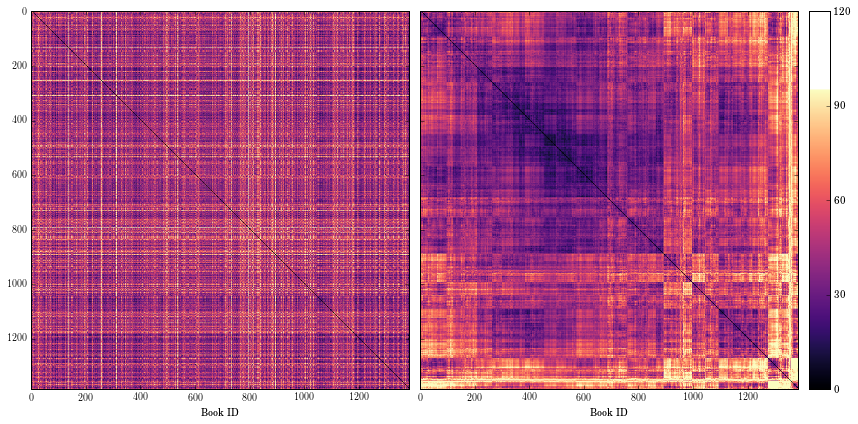

In [44]:
cap = 50

fig = plt.figure(figsize=(15,7.5))
ax1 = fig.add_axes([0.15,0.2,0.35,0.7])
# screw memory...I have a SSD!
# plt.subplot(1,2,1)
allDistances_capped = allDistancesCentered.copy()
allDistances_capped[allDistancesCentered > cap] = cap
ax1.imshow(allDistances_capped,cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax1.set_xlabel('Book ID')
# plt.ylabel('book num')

allDistancesSorted_capped = allDistancesSorted.copy()
allDistancesSorted_capped[allDistancesSorted > cap] = cap
ax2 = fig.add_axes([0.51,0.2,0.35,0.7])
ax2.imshow(allDistancesSorted_capped,cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax2.set_xlabel('Book ID')
ax2.set_yticklabels([])

ax3 = fig.add_axes([0.86,0.2,0.04,0.7])
my_cmap = np.tile(np.arange(allDistancesSorted.shape[0]),(100,1)).transpose()
print(my_cmap)
ax3.imshow(my_cmap,cmap=plt.get_cmap("magma"),origin="lower")
ax3.set_xticks([])
ax3.set_xticklabels([])
ax3.yaxis.tick_right()
ax3.set_yticks([0,1752*.25,1752*.5,1752*.75,1752])
ax3.set_yticklabels(map(int,[0,120*.25,120*.5,120*.75,120]))

mysavefig("clustered-matrix-2-{}.pdf".format(cap),openfig=True,date_prefix=True,folder=this_dir)

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1382 1382 1382 ..., 1382 1382 1382]
 [1383 1383 1383 ..., 1383 1383 1383]
 [1384 1384 1384 ..., 1384 1384 1384]]


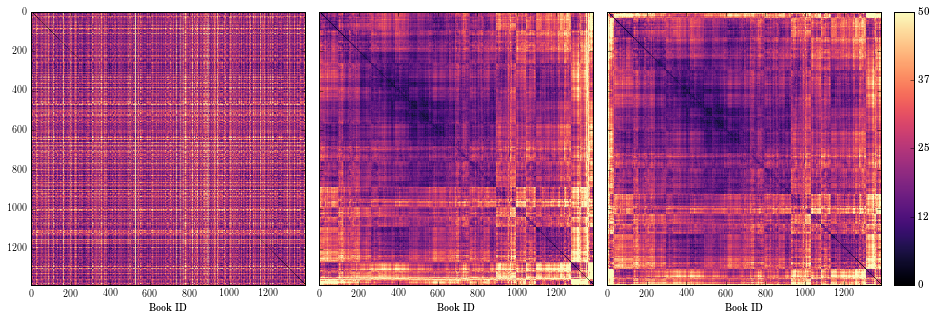

In [45]:
cap = 50
numel = len(q)-1

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_axes([0.15,0.15,0.8/3,0.8-.04])
# screw memory...I have a SSD!
# plt.subplot(1,2,1)
allDistances_capped = allDistancesCentered.copy()
allDistances_capped[allDistancesCentered > cap] = cap
ax1.imshow(allDistances_capped,cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax1.set_xlabel('Book ID')
# plt.ylabel('book num')

allDistancesSorted_capped = allDistancesSorted.copy()
allDistancesSorted_capped[allDistancesSorted > cap] = cap
ax2 = fig.add_axes([0.15+0.8/3,0.15,0.8/3,0.8-.04])
ax2.imshow(allDistancesSorted_capped,cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax2.set_xlabel('Book ID')
ax2.set_yticklabels([])

# go and find the shift! put the story with the greatest distance between neighbors in the
# upper left
shift = list(map(lambda x: x%len(q),np.arange(allDistancesSorted.shape[0])+np.argmax(allDistancesSorted.sum(axis=1))))
ax3 = fig.add_axes([0.15+0.8/3+0.8/3,0.15,0.8/3,0.8-.04])
ax3.imshow(allDistancesSorted_capped[shift,:][:,shift],cmap=plt.get_cmap("magma"))
# # ax1.colorbar()
# # plt.colorbar(cax,shrink=0.8)
# # plt.clim([0,120])
# plt.title('unsorted distance matrix')
ax3.set_xlabel('Book ID')
ax3.set_yticklabels([])

ax4 = fig.add_axes([0.15+0.8/3+0.8/3+0.8/3,0.15,0.03,0.8-.04])
my_cmap = np.tile(np.arange(allDistancesSorted.shape[0]),(100,1)).transpose()
print(my_cmap)
ax4.imshow(my_cmap,cmap=plt.get_cmap("magma"),origin="lower")
ax4.set_xticks([])
ax4.set_xticklabels([])
ax4.yaxis.tick_right()
ax4.set_yticks([0,numel*.25,numel*.5,numel*.75,numel])
ax4.set_yticklabels(map(int,[0,cap*.25,cap*.5,cap*.75,cap]))

mysavefig("clustered-matrix-3-{}.pdf".format(cap),openfig=True,date_prefix=True,folder=this_dir)

[0.0, 572.03045073810449, 572.03045073810449, 0.0]
[5.0, 5.0, 15.0, 15.0]
[0.0, 652.67419036998524, 652.67419036998524, 0.0]
[25.0, 25.0, 35.0, 35.0]
[572.03045073810449, 891.02271933629254, 891.02271933629254, 652.67419036998524]
[10.0, 10.0, 30.0, 30.0]
[0.0, 624.19628836902586, 624.19628836902586, 0.0]
[65.0, 65.0, 75.0, 75.0]
[0.0, 808.50936091104984, 808.50936091104984, 624.19628836902586]
[55.0, 55.0, 70.0, 70.0]
[0.0, 995.09667918333184, 995.09667918333184, 808.50936091104984]
[45.0, 45.0, 62.5, 62.5]
[891.02271933629254, 1935.5089549712893, 1935.5089549712893, 995.09667918333184]
[20.0, 20.0, 53.75, 53.75]
[7009.7240023530567, 33.75]
[ 0.11828882  0.05625   ]
0.05625
[ 0.72958075  0.22333333]
[0.0, 529.77979829202934, 529.77979829202934, 0.0]
[85.0, 85.0, 95.0, 95.0]
[0.0, 719.59364443699212, 719.59364443699212, 0.0]
[105.0, 105.0, 115.0, 115.0]
[0.0, 555.61826499805193, 555.61826499805193, 0.0]
[135.0, 135.0, 145.0, 145.0]
[0.0, 799.65782635389519, 799.65782635389519, 555.6182

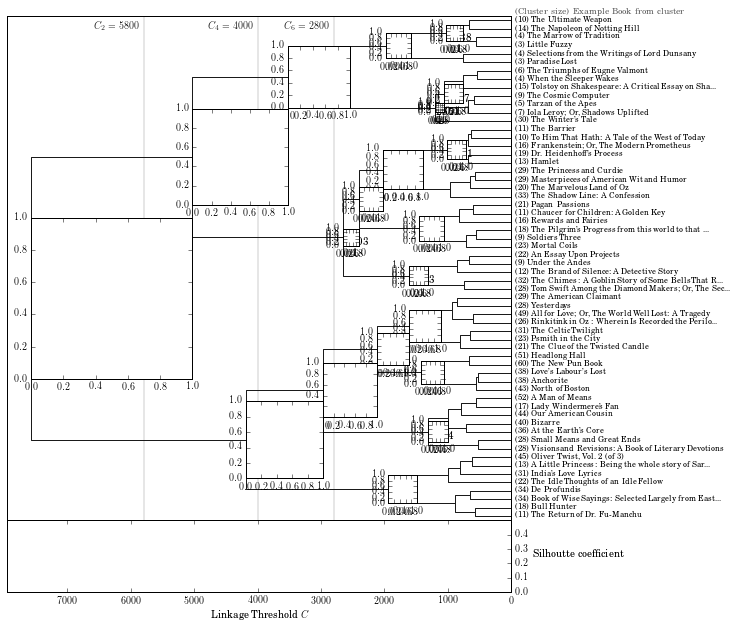

In [102]:
from matplotlib.colors import rgb2hex

def printcolor(k,yes='yes',fit=fit2):
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    return rgb2hex(cm(fit[k-fit2.shape[0]-1,2]/fit[-1,2]))

def llf(k):
    chars = 50
    all_ind = get_cluster_indices_from_id(fit2,k)
#     print(k,all_ind)
    # go get the submatrix
    # allDistances[[1,2,3],:][:,[1,2,3]]
    submat = allDistances[all_ind,:][:,all_ind]
#     print(submat)
    distances = submat.sum(axis=0)
#     print(distances)
    indices_sorted = sorted(range(len(all_ind)),key=lambda i: distances[i])
    all_ind_sorted = all_ind[indices_sorted]
#     print(all_ind_sorted)
#     print(all_ind_sorted[0])
    if len(all_ind_sorted) == 0:
        print("no book found?")
        print(k)
    b = q[int(all_ind_sorted[0])]
    # b = q[627]
    if len(b.title) > chars:
        s = "({}) {}...".format(len(all_ind),b.title[:chars-3].replace("\n",": ").replace("&","\&"))
    else:
        s = "({}) {}".format(len(all_ind),b.title.replace("\n",": ").replace("&","\&"))
    # print('node {0} index {1}'.format(k-fit.shape[0],k-fit.shape[0]-1))
    s = s.encode("ascii","ignore").decode("ascii")
    return s
    

# R = dendrogram(fit,
#                p=p,
#                truncate_mode='lastp',
#                link_color_func=lambda k: printcolor(k,yes='n'),
#                ax=ax,
#                # leaf_rotation=0.,
#                # labels=alltitles,
#                # leaf_label_func=llf,
#                # leaf_label_func=lambda k: q[k].title,
#                # orientation='right',
#                orientation='top',
#                # no_labels=True,
#                )

p=60
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([.2,.2,.7,.7])
# ax.set_xscale('log',basex=10)
# ax.set_xlim([50,10000])
# ax.set_xlim(np.log10([50,10000]))
# colors = ["k" for i in range(p+1)]
R = dendrogram(fit2,
               p=p,
               link_color_func=lambda k: "0.1",
               truncate_mode="lastp",
               orientation="left",
               distance_sort="ascending",
               ax=ax,
               # leaf_label_func=lambda k: k-fit.shape[0]+1,
               leaf_label_func=llf,
               leaf_font_size=8,
               # link_color_func=lambda k: colors[k],
               # annotate_above=10000,
               )

y_range = ax.get_ylim()
def add_line(x,i):
    ax.plot([x,x],y_range,zorder=1,color=".9",linewidth=2)
    # example from mpl
#     bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2)
#     t = ax.text(0, 0, "Direction", ha="center", va="center", rotation=45,
#             size=15,
#             bbox=bbox_props)
    bbox_props = dict(boxstyle="square,pad=0.3", fc=".9", ec=".6", lw=1)
    ax.text(x+80,y_range[1]-8,"{}".format(i),color=".1",ha="right",va="top",linespacing=1.8,size=10) # ,bbox=bbox_props)
# thresholds = [29000,20000,11000,5500]
ax.text(-60,y_range[1]+3,"(Cluster size) Example Book from cluster",color=".4",size=9)

for i,d,c in zip(R['icoord'],R['dcoord'],R['leaves']):
    y = 0.5 * sum(i[1:3])
    # print(i)
    x = d[1]
    print(d)
    print(i)
    # print(d)
    # print(x,y)
    # ax.plot(y,x, 'ro')
#     plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
#                  textcoords='offset points',
#                  va='top', ha='center')
    if x>1000:
        ax.text(x-30,y,c,color="0",ha="left",va="top",linespacing=1.8,size=10)
        
#         subx = fig.add_axes([ax.transLimits.transform_point([d[1],i[0]])[0],
#                              ax.transLimits.transform_point([d[1],i[0]])[1],
#                              ax.transLimits.transform_point([d[0],i[1]])[0],
#                              ax.transLimits.transform_point([d[0],i[1]])[0]])
        
        rects = [ax.get_xlim()[0]-np.min([d[1]-d[0],d[2]-d[3]]),i[2]-i[1]]
        rects_notflipped = [np.min([d[1]-d[0],d[2]-d[3]]),i[2]-i[1]]
        print(rects)
        max_size_ax = ax.transLimits.transform_point(rects)
        # max_size_ax[0] = 1-max_size_ax
        print(max_size_ax)
        max_size_ax = np.min(max_size_ax)
        b_left = np.array([x,y])
        b_ax = ax.transLimits.transform_point(b_left)+np.array([0,-max_size_ax/2])
        b_ax[0] += .0*max_size_ax
        b_ax_subrect = .2+.&*.b_ax
        print(max_size_ax)
        print(b_ax)
        subx = fig.add_axes([b_ax[0],b_ax[1],max_size_ax*.9*.7,max_size_ax*.9*.7],frameon=False)
        subx.plot()
    print("="*40)
        

# subx = fig.add_axes([.2,.5,.1,.1])

thresholds = [5800,4000,2800]
nc = [2,4,6]
for i,t in enumerate(thresholds):
    # add_line(t,i)
    # add_line(t,"$C_{1} = {0}$\n{1} Clusters".format(t,nc[i]))
    add_line(t,"$C_{1} = {0}$".format(t,nc[i]))
# ax.set_xlim(np.log10([50,10000]))
# ax.set_xlim([400,11000])
ax.set_xticks([])
ax2 = fig.add_axes([.2,.1,.7,.1])
ax2.plot(x,y,'.1',linewidth=1.5)
ax2.set_xlim(ax.get_xlim())
ax2.yaxis.tick_right()
# ax2.set_ylim([0,1])
# ax2.set_yticks([0,.2,.4,.6,.8])
ax2.set_ylim([0,.5])
ax2.set_yticks([0,.1,.2,.3,.4])
# ax2.set_ylabel("Silhoutte coefficient")
ax2.text(-350,.25,"Silhoutte coefficient")
ax2.set_xlabel("Linkage Threshold $C$")
# mysavefig("dendrogram-left-p{}-topstories.pdf".format(p),openfig=True,date_prefix=True,folder=this_dir)

In [74]:
ax.transLimits

BboxTransformFrom(TransformedBbox(Bbox([[7950.136278141014, 0.0], [0.0, 600.0]]), TransformWrapper(BlendedAffine2D(IdentityTransform(),IdentityTransform()))))

In [80]:
ax.transAxes.transform_point([1,0])

array([ 720.,  240.])

In [77]:
ax.transLimits.transform_point([7950.13,0])

array([  7.89689735e-07,   0.00000000e+00])

In [78]:
ax.transLimits.transform

array([ 1.,  0.])

In [79]:
ax.transScale.transform_point([7950.13,0])

array([ 7950.13,     0.  ])

In [ ]:
ax.get_

In [30]:
def get_cluster_indices2(model,threshold=70000):
    cluster_list = np.arange(allDistances.shape[0],dtype=int)
    # march through the model and cluster the stories as they are clustered in each step of model
    i = 0
    merge = model[i]
    while merge[2] < threshold:
        # print(merge)
        # print(int(merge[0]))
        a = cluster_list==int(merge[0])
        cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
        cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
        i+=1
        merge = model[i]
        
    # print(cluster_list[:10])
    # print(cluster_list[1730:1740])
    clusters = np.unique(cluster_list)
    a = np.arange(allDistances.shape[0],dtype=int)
    indices = [a[cluster_list==c] for c in clusters]
    # num_clusters = len(indices)
    # cluster_sizes = list(map(len,indices))
    # print('found {0} clusters of sizes:'.format(num_clusters))
    # print(cluster_sizes)
    return indices,cluster_list

def get_sorted(all_ind):
    # go get the submatrix
    # allDistances[[1,2,3],:][:,[1,2,3]]
    submat = allDistances[all_ind,:][:,all_ind]
    # print(submat)
    distances = submat.sum(axis=0)
    # print(distances)
    indices_sorted = sorted(range(len(all_ind)),key=lambda i: distances[i])
    all_ind_sorted = all_ind[indices_sorted]
    distances_sorted = distances[indices_sorted]
    # print(all_ind_sorted)
    # make sure they're sorted the right way!
    # print(distances_sorted)
    assert distances_sorted[0] < distances_sorted[1]
    titles_sorted = ["" for i in range(len(all_ind_sorted))]
    chars = 50
    for i,ind in enumerate(all_ind_sorted):
        b = q[int(ind)]
        if len(b.title) > chars:
            titles_sorted[i] = "{}. {}...".format(i+1,b.title[:chars-3].replace("\n",": "))
        else:
            titles_sorted[i] = "{}. {}".format(i+1,b.title.replace("\n",": "))
    return all_ind_sorted,titles_sorted
    
    
for i,t in enumerate(thresholds[:1]):
    # add_line(t,i)
    ind,cluster_list = get_cluster_indices2(fit,threshold=t)
    # ind,nc,cs = get_cluster_indices(fit,threshold=t)
    print(ind)
    # the indices...
    print(cluster_list)
    # for each story, which cluster it is in, by id (a reverse lookup of ind)
    ind_sorted,titles_sorted = get_sorted(ind[0])
    print(ind_sorted[:10])
    print(titles_sorted[:10])

[array([   2,    6,    9,   25,   29,   30,   34,   40,   43,   44,   46,
         48,   58,   60,   65,   70,   74,   81,   86,   88,   89,   94,
         97,  103,  104,  108,  117,  128,  129,  139,  140,  141,  154,
        157,  163,  165,  173,  175,  183,  184,  187,  192,  200,  211,
        224,  228,  229,  236,  243,  250,  255,  256,  261,  271,  290,
        307,  312,  314,  323,  326,  330,  332,  333,  336,  346,  366,
        369,  381,  398,  408,  409,  413,  419,  430,  441,  442,  444,
        453,  461,  466,  472,  481,  482,  484,  488,  491,  504,  522,
        523,  526,  527,  550,  553,  555,  559,  563,  567,  586,  587,
        591,  604,  608,  614,  615,  622,  630,  634,  642,  650,  651,
        661,  663,  664,  667,  671,  673,  683,  695,  698,  700,  702,
        705,  707,  708,  709,  711,  714,  715,  721,  724,  725,  735,
        738,  751,  755,  760,  761,  766,  767,  770,  772,  776,  777,
        785,  794,  804,  817,  822,  823,  829,  

In [31]:
# now let's also plot them
def plot_clusters(clusters,data,v=True,fix_ylim=True,xspacing=.01,investigate=False,save=False,threshold=1000):
    # we are going to make plots of max width 3
    num_x = np.min([3,len(clusters)])
    num_y = np.ceil(len(clusters)/num_x)
    xspacing = .03
    yspacing = .03
    xoffset = .07
    yoffset = .07
    xwidth = (1.-xoffset)/(num_x)-xspacing
    yheight = (1.-yoffset)/(num_y)-yspacing
    print('xwidth is {0}'.format(xwidth))
    print('yheight is {0}'.format(yheight))
    
    # go compute the ybounds:
    calc_ylim = [100.0,-100.0]
    for cluster in clusters:
        c_max = data[cluster[0][:20],:].max()
        c_min = data[cluster[0][:20],:].min()
        calc_ylim[0] = np.min([calc_ylim[0],c_min])
        calc_ylim[1] = np.max([calc_ylim[1],c_max])
        
    chars = 60
    
    scale_factor_x = 5
    scale_factor_y = 5*1.25
    if investigate:
        scale_factor_x = 10
        scale_factor_y = 10*1.25
    fig = plt.figure(figsize=(scale_factor_x*num_x,scale_factor_y*num_y))
    for i,cluster in enumerate(clusters):
        print(i)
        print("====")
        # print((i-i%num_x))
        # ind = np.argsort(w[:,sv+svstart])[-20:]
        ax1rect = [xoffset+(i%num_x)*(xspacing+xwidth),1.-yheight-yspacing-(int(np.floor((i-i%num_x)/num_x))*(yspacing+yheight))+yheight*.2,xwidth,yheight*.8]
        ax1 = fig.add_axes(ax1rect)
        ax1books_rect = ax1rect.copy()
        ax1books_rect[1] -= yheight*.2
        ax1books_rect[3] = yheight*.2
        ax1books = fig.add_axes(ax1books_rect)
        # ax1books.text?
        # ax.set_title('20 closest positive correlates')
        
        if v:
            print('-'*80)
            print('20 closest positive correlates:')
            # print(cluster)
        j=0
        for index,title in zip(*cluster):
            if j+1 > 20:
                break
            if investigate:
                ax1.plot(data[index],label="{} ({})".format(title.encode("ascii","ignore").decode("ascii"),q[int(index)].gutenberg_id))
            else:
                ax1.plot(data[index],color=".4",label=None)
            # plt.plot(big_matrix_mean0[i],color=".4")
            if v:
                print(index,title)
            if j<5:
                ax1books.text(0.0,.8-j*.2,"{} ({})".format(title.encode("ascii","ignore").decode("ascii"),q[int(index)].gutenberg_id),fontsize=10)
            j+=1
        ax1.plot(data[cluster[0],:].mean(axis=0),color="#ff6700",linewidth=2,label="Threshold {} Cluster {} ({})".format(threshold,i+1,len(cluster[0])))
        # ax1.set_xticklabels([])
        ax1.legend(loc="upper right")

        # ax1.axis('off')
        ax1books.axis('off')
        
        props = dict(boxstyle='square', facecolor='white', alpha=1.0)
        # fig.text(ax1rect[0]+.03/xwidth, ax1rect[1]+ax1rect[3]-.03/yheight, letters[i],
        if fix_ylim:
            my_ylim = calc_ylim
        else:
            my_ylim = ax1.get_ylim()
        ax1.text(.035*200, my_ylim[0]+.965*(my_ylim[1]-my_ylim[0]), letters[i],
                     fontsize=14,
                     verticalalignment='top',
                     horizontalalignment='left',
                     bbox=props)

        if fix_ylim:
            ax1.set_ylim(calc_ylim)
        if fix_ylim and i%num_x > 0:
            ax1.set_yticklabels([])
        if True: # i<num_x*(num_y-1): # only on the bottom row
            ax1.set_xticklabels([])
            
    if save:
        # mysavefig('SV{0}.svg'.format('4-6'))
        mysavefig("clustered-timeseries-threshold-{}-num-{}.png".format(t,len(clusters)),
                  folder=this_dir,
                  openfig=False)
        mysavefig("clustered-timeseries-threshold-{}-num-{}.pdf".format(t,len(clusters)),
                  folder=this_dir,
                  openfig=True)

xwidth is 0.43499999999999994
yheight is 0.8999999999999999
0
====
1
====
xwidth is 0.28
yheight is 0.43499999999999994
0
====
1
====
2
====
3
====
xwidth is 0.28
yheight is 0.28
0
====
1
====
2
====
3
====
4
====
5
====
6
====
7
====
8
====


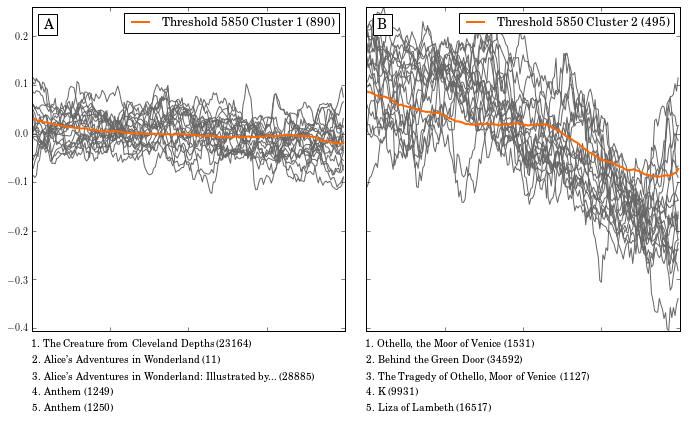

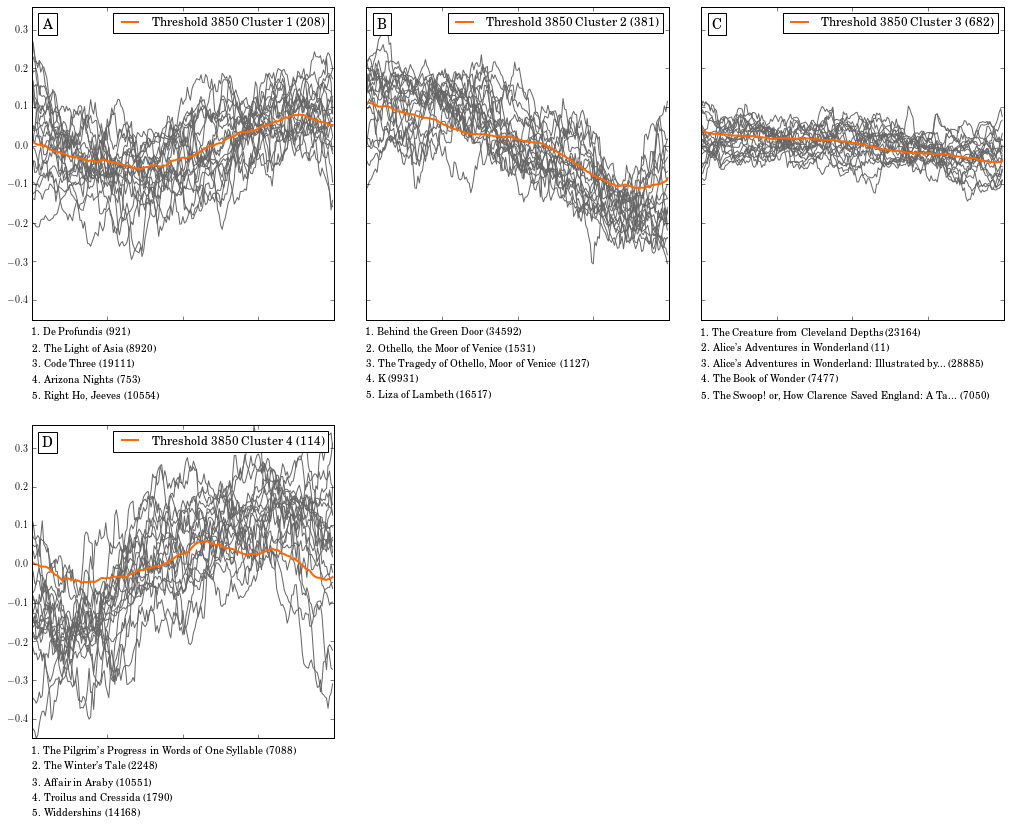

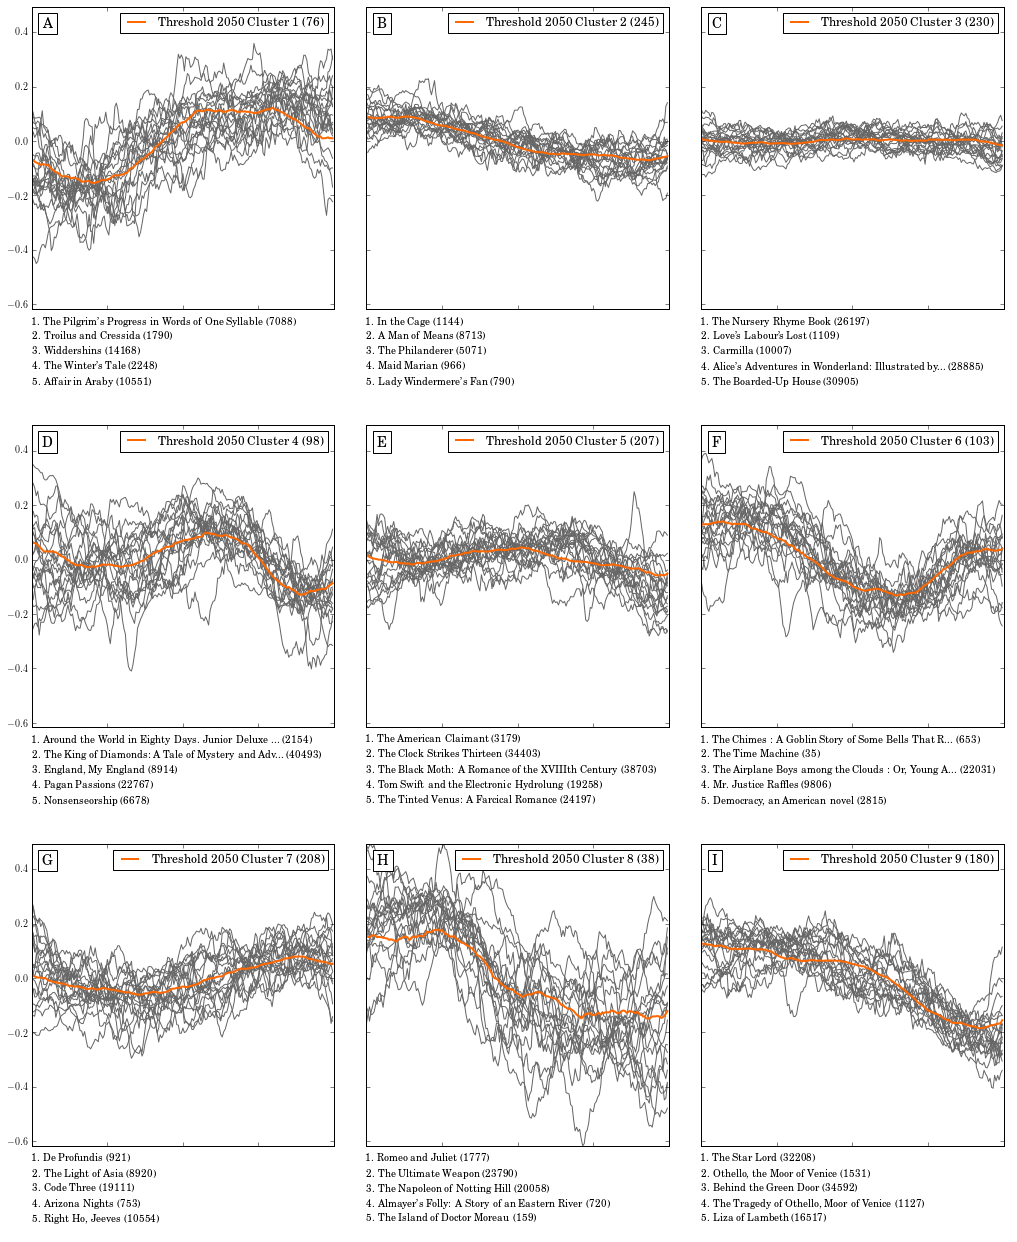

In [32]:
for i,t in enumerate(thresholds):
    # add_line(t,i)
    ind,cluster_list = get_cluster_indices2(fit2,threshold=t)
    # ind,nc,cs = get_cluster_indices(fit,threshold=t)
    # print(ind)
    # the indices...
    # print(cluster_list)
    # for each story, which cluster it is in, by id (a reverse lookup of ind)
    ind_sorted,titles_sorted = get_sorted(ind[0])
    # print(ind_sorted[:10])
    # print(titles_sorted[:10])
    
    # go and sort all of them
    ind_sorted_all = [get_sorted(i) for i in ind]
    # print(ind_sorted_all)
    
    # now let's try our new plotting function
    plot_clusters(ind_sorted_all,big_matrix_mean0,v=False,save=True,threshold=t) #,fix_ylim=[5.5,5.8])

In [38]:
ind,c_i = get_cluster_indices2(fit2,5500)
metrics.silhouette_score(allDistancesCentered, c_i, metric='euclidean')

0.27404674023229753

In [37]:
def get_cluster_indices3(model,threshold):
    cluster_list = np.arange(allDistances.shape[0],dtype=int)
    # march through the model and cluster the stories as they are clustered in each step of model
    i = 0
    merge = model[i]
    while merge[2] < threshold:
        # print(merge)
        # print(int(merge[0]))
        a = cluster_list==int(merge[0])
        cluster_list[cluster_list==int(merge[0])] = i+allDistances.shape[0]
        cluster_list[cluster_list==int(merge[1])] = i+allDistances.shape[0]
        i+=1
        merge = model[i]
    return cluster_list

In [44]:
x = np.linspace(7000,10,100)
print(x)
y = np.zeros(len(x))
for i in tqdm(range(len(x))):
    # print(j)
    y[i] = metrics.silhouette_score(allDistancesCentered, get_cluster_indices3(fit2,x[i]), metric='euclidean')  
# y = [metrics.silhouette_score(allDistancesCentered, get_cluster_indices3(fit2,i), metric='euclidean') for i in x]

100%|██████████| 100/100 [01:47<00:00, 10.71s/it]

[ 7000.          6929.39393939  6858.78787879  6788.18181818  6717.57575758
  6646.96969697  6576.36363636  6505.75757576  6435.15151515  6364.54545455
  6293.93939394  6223.33333333  6152.72727273  6082.12121212  6011.51515152
  5940.90909091  5870.3030303   5799.6969697   5729.09090909  5658.48484848
  5587.87878788  5517.27272727  5446.66666667  5376.06060606  5305.45454545
  5234.84848485  5164.24242424  5093.63636364  5023.03030303  4952.42424242
  4881.81818182  4811.21212121  4740.60606061  4670.          4599.39393939
  4528.78787879  4458.18181818  4387.57575758  4316.96969697  4246.36363636
  4175.75757576  4105.15151515  4034.54545455  3963.93939394  3893.33333333
  3822.72727273  3752.12121212  3681.51515152  3610.90909091  3540.3030303
  3469.6969697   3399.09090909  3328.48484848  3257.87878788  3187.27272727
  3116.66666667  3046.06060606  2975.45454545  2904.84848485  2834.24242424
  2763.63636364  2693.03030303  2622.42424242  2551.81818182  2481.21212121
  2410.606060

(7000, 0)

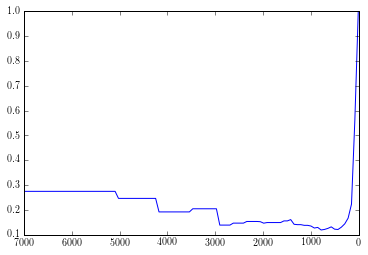

In [47]:
plt.plot(x,y)
plt.xlim([7000,0])

In [50]:
y

array([ 0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.27404674,  0.27404674,
        0.27404674,  0.27404674,  0.27404674,  0.24565135,  0.24565135,
        0.24565135,  0.24565135,  0.24565135,  0.24565135,  0.24565135,
        0.24565135,  0.24565135,  0.24565135,  0.24565135,  0.24565135,
        0.19115451,  0.19115451,  0.19115451,  0.19115451,  0.19115451,
        0.19115451,  0.19115451,  0.19115451,  0.19115451,  0.19115451,
        0.20379803,  0.20379803,  0.20379803,  0.20379803,  0.20379803,
        0.20379803,  0.20379803,  0.20379803,  0.13798199,  0.13798199,
        0.13798199,  0.13798199,  0.14593893,  0.14593893,  0.14593893,
        0.14593893,  0.15262675,  0.15262675,  0.15262675,  0.15

In [137]:
import matplotlib.cm as cm
def sil_plot(t):
    cluster_labels = get_cluster_indices3(fit2,t)
    silhouette_avg = metrics.silhouette_score(allDistancesCentered, get_cluster_indices3(fit2,t))
    sample_silhouette_values = metrics.silhouette_samples(allDistancesCentered, get_cluster_indices3(fit2,t))
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    fig = plt.figure(figsize=(8,15))
    ax1 = fig.add_axes([.2,.2,.7,.7])
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(allDistancesCentered[0,:]) + (n_clusters + 1) * 10])
    for i,c in enumerate(np.unique(cluster_labels)):
        # print(c)
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == c]
        # print(len(sample_silhouette_values[cluster_labels == c]))

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.09, y_lower + 0.5 * size_cluster_i, str(c))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    

In [138]:
cluster_indices = get_cluster_indices3(fit2,5000)

In [139]:
cluster_indices

array([2766, 2766, 2766, ..., 2766, 2766, 2766])

In [140]:
np.unique(cluster_indices)

array([2763, 2765, 2766])

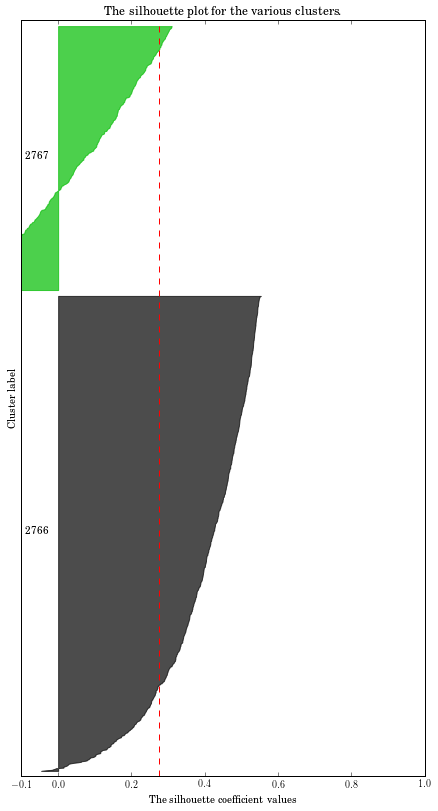

In [141]:
sil_plot(6000)

In [181]:
import matplotlib.cm as cm
def sil_plot_nc(n_clusters):
    t = 7500
    step = 500
    n = 1
    while n != n_clusters:
        if n>n_clusters:
            t = t + step
            step = step/2.0
        if n<n_clusters:
            t = t - step
        # for my own amusement
        # print(t)
        cluster_labels = get_cluster_indices3(fit2,t)
        n = len(np.unique(cluster_labels))
    print(n,t)
    silhouette_avg = metrics.silhouette_score(allDistancesCentered, get_cluster_indices3(fit2,t))
    sample_silhouette_values = metrics.silhouette_samples(allDistancesCentered, get_cluster_indices3(fit2,t))
    y_lower = 10
    n_clusters = len(np.unique(cluster_labels))
    fig = plt.figure(figsize=(4,6))
    ax1 = fig.add_axes([.2,.2,.7,.7])
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(allDistancesCentered[0,:]) + (n_clusters + 1) * 10])
    cluster_labels_uniq = np.unique(cluster_labels)
    cluster_labels_uniq.sort()
    for i,c in enumerate(cluster_labels_uniq):
        # print(c)
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == c]
        # print(len(sample_silhouette_values[cluster_labels == c]))

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # color = cm.spectral(float(i) / n_clusters)
        color=".5"
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.09, y_lower + 0.5 * size_cluster_i, str(c))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot for the $N={}$ clusters.".format(n_clusters))
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    mysavefig("silhouette-distribution-{}.pdf".format(n_clusters),
                  folder=this_dir,
                  openfig=False)

2 7000
3 5000
4 4000
5 3500
6 2750.0
7 2500
8 2250.0
9 2062.5
10 2000
11 1937.5


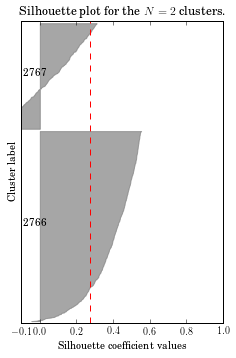

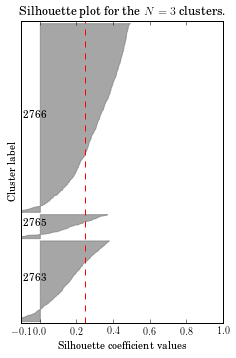

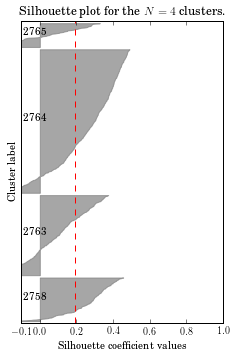

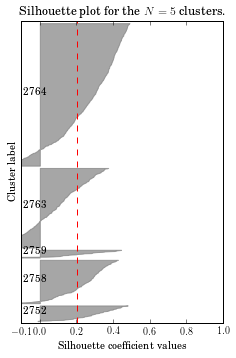

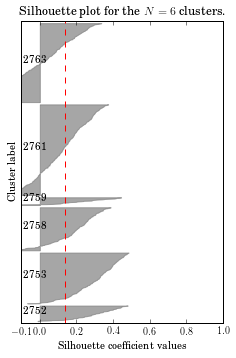

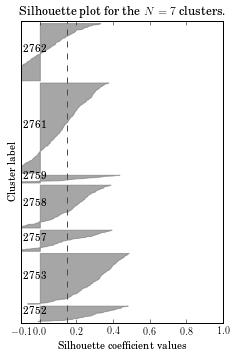

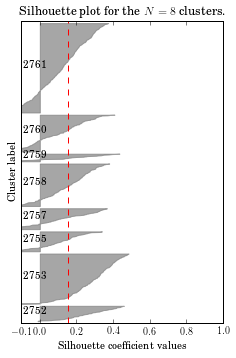

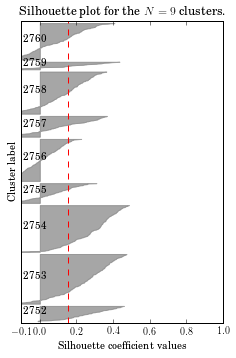

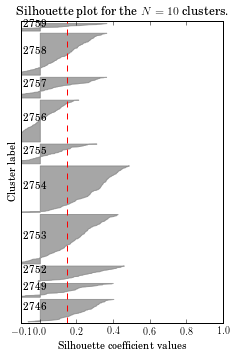

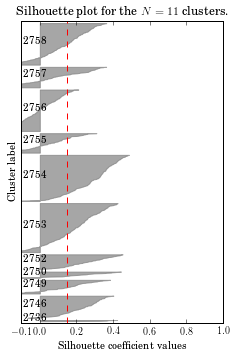

In [182]:
for i in range(2,12):
    sil_plot_nc(i)